In [13]:
import os
os.chdir("/Users/users/lourens/RDMP/master_research/code/SGQ_classification/")

# SGQ Classification
This notebook contains code that performs Star, Galaxy & QSO classification based on the output of an SDR-NNP model. This notebook will demonstrate the performance of the following different classifiers:
- A k-nearest neighbors classifier (KNN)
- Three different support vector classifiers (SVC) with different kernels (i.e. linear, polynomial (3rd degree) and radial basis function (RBF)).
- A multi-layer perceptron classifier (MLPC) also dubbed neural network classifier (NNC)
- A random forest classifier from the XGBoost module
- A dummy classifier (for establishing a baseline performance).

when applied to data produced by an SDR-NNP model trained to emulate the projection of the STAR dataset (derived from the CPz catalog) by sharpened LMDS. The same classifiers can of course be applied to different SDR-NNP models trained on different datasets but for the sake of brevity this notebook will only show one case.

## Imports

In [14]:
import numpy as np
from astropy.table import Table

import tensorflow as tf
from sklearn.model_selection import train_test_split

# A couple of different classifiers
from SHARC.classifiers import SDRNNPClassifier # classifier following sklearn API that combines any SDR-NNP model with a given sklearn classifier
from sklearn.neighbors import KNeighborsClassifier # for KNN classification
from sklearn.svm import SVC # for SVM classification
from sklearn.neural_network import MLPClassifier # for Neural Network classification
from xgboost import XGBClassifier # for RF classification
from sklearn.dummy import DummyClassifier # for Dummy classification

import matplotlib.pyplot as plt
from SHARC.plot_funcs import CustomConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# colors used for different classifiers in HDBSCAN paper
colors_STAR = ["Kmag-Y3mag", "Kmag-J3mag", "Kmag-Z3mag", "Kmag-H3mag", "J3mag-K3mag",
               "Y3mag-K3mag", "J3mag-W1mag", "Y3mag-W1mag", "Jmag-Kmag", "H3mag-K3mag",
               "H3mag-W1mag", "Ymag-Kmag", "Hmag-Y3mag", "Y3mag-W2mag", "J3mag-W2mag",
               "imag-g3mag", "Z3mag-W1mag", "Z3mag-K3mag", "zmag-u3mag", "Hmag-J3mag"] # from Table 3 (italics, i.e. colours only)

method = "LMDS"
method_path = os.path.join("/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR", method)
model = "NNPModel"
model_path = os.path.join(method_path, model)

seed = 42

## Import Data

In [15]:
# load fits table
table = Table.read("/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR/CPz_STAR_dataset.fits.gz", format="fits")

# extract color data & label data from table
X = np.ascontiguousarray(table[colors_STAR].to_pandas().values) # ensures X is C_CONTIGUOUS instead of F_CONTIGUOUS
labels = table[["Hclass"]].to_pandas().values.ravel()
labels = labels.astype('int8')

print(X.shape, labels.shape)

(48686, 20) (48686,)


## Split the SDR-NNP embedded data in a training and test set
The high dimensional colour data (i.e. `X`) together with the relevant class labels will now be split into training and test sets with the test set constituting 20% of the full dataset. The test sets will later be used to evaluate the trained classifier. Note that the split is stratified with respect to the class labels. This is to ensure datasets with a large class imbalance still have enough samples of the rarest classes in the test set for proper evaluation.

In [16]:
test_size = 0.2
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=test_size, shuffle=True, stratify=labels, random_state=seed)

## Use a KNN classifier to classify the data
Now it's time to classify the data. For this I use the `SDRNNPClassifier` class whose implementation, which is in accordance with the sklearn API, can be found in `classifiers.py`. All this class does is combine any given SDR-NNP model with a given classifier into a single pipeline. This makes classification of unseen data that is still in the high dimensional color space a breeze since we don't have to project it ourselves beforehand. The classifier will do that for us. Another advantage is that we can serialize trained `SDRNNPClassifier` instances using tools like e.g. "pickle" and store them for later usage.

The code below trains a KNN classifier using 100 neighbors and a Euclidean metric to compute distances. The trained classifier is then used to predict class labels for the test set. The values for accuracy, precision, recall and F1 score are printed. I also added plots of the decision boundaries of the trained classifier and the confusion matrix.

Accuracy: 0.976484
Precision:
	STAR : 0.992131
	GAL : 0.978915
	QSO : 0.921773

Recall:
	STAR : 0.978655
	GAL : 0.991296
	QSO : 0.842670

F1 score:
	STAR : 0.985347
	GAL : 0.985067
	QSO : 0.880448



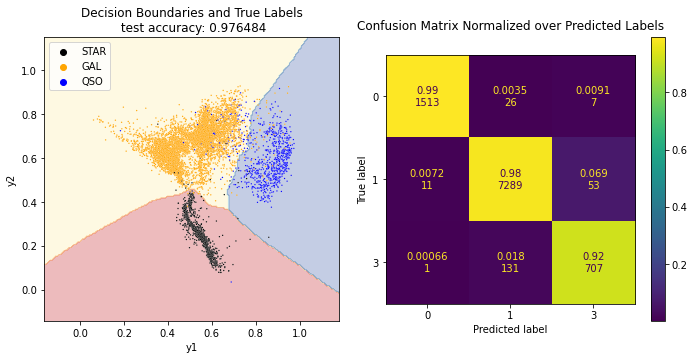

In [17]:
clf = SDRNNPClassifier(nnp_model_path=model_path, classifier=KNeighborsClassifier(n_neighbors=100, p=2, metric="minkowski")) # with n_neighbors=100 the probabilities can be valid up to 2 digits
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=10, h=5)

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

fig.tight_layout()
plt.show()

## Use SVC to classify the data

The code cells below use support vector classifiers for classification with three different types of kernels:
- Linear
- Polynomial (3rd degree)
- Radial basis function (RBF) 

From experience with different SDR-NNP classifiers I found that SVC with an RBF kernel is most robust. For the other classifiers I made the following observations. Linear SVC's don't perform well in convex regions. Another case where linear SVC's lack in performance is when data samples with the same class label are distributed over multiple distinct clusters which are separated from each other by data clusters with a different overall class label. Polynomial SVC's tend to suffer from the same issues as linear SVC's but to a lesser extent.

### Linear SVC
Note: For large datasets consider using `sklearn.svm.linearSVC` instead as it is more scalable!

Accuracy: 0.975970
Precision:
	STAR : 0.991475
	GAL : 0.978127
	QSO : 0.923784

Recall:
	STAR : 0.978008
	GAL : 0.991296
	QSO : 0.837902

F1 score:
	STAR : 0.984696
	GAL : 0.984667
	QSO : 0.878750



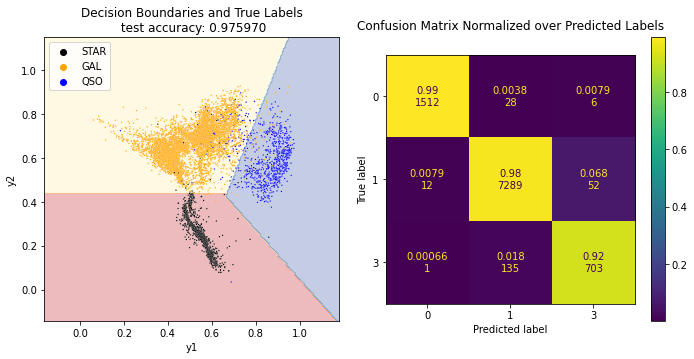

In [18]:
clf = SDRNNPClassifier(nnp_model_path=model_path, classifier=SVC(kernel="linear", C=1.0, random_state=seed)) # NB: to enable clf.predict_proba set probability=True
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=10, h=5)

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

fig.tight_layout()
plt.show()

### SVC 3rd degree polynomial

Accuracy: 0.975765
Precision:
	STAR : 0.991475
	GAL : 0.977224
	QSO : 0.929239

Recall:
	STAR : 0.978008
	GAL : 0.991976
	QSO : 0.829559

F1 score:
	STAR : 0.984696
	GAL : 0.984545
	QSO : 0.876574



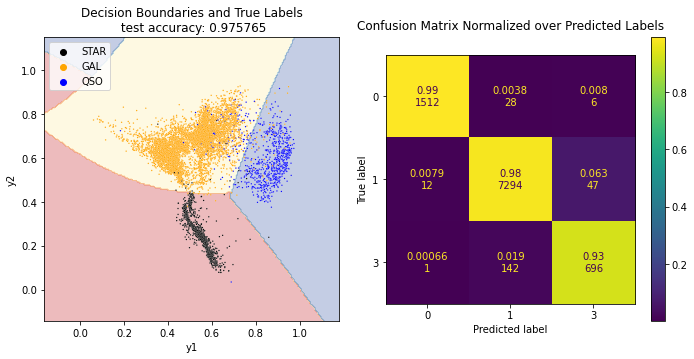

In [19]:
degree = 3
gamma = 1.0
coef0 = 0.0
clf = SDRNNPClassifier(nnp_model_path=model_path, classifier=SVC(C=1.0, kernel="poly", degree=degree, gamma=gamma, coef0=coef0, random_state=seed)) # NB: to enable clf.predict_proba set probability=True
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=10, h=5)

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

fig.tight_layout()
plt.show()

### SVC RBF


Accuracy: 0.976381
Precision:
	STAR : 0.993438
	GAL : 0.977751
	QSO : 0.928287

Recall:
	STAR : 0.979301
	GAL : 0.992112
	QSO : 0.833135

F1 score:
	STAR : 0.986319
	GAL : 0.984879
	QSO : 0.878141



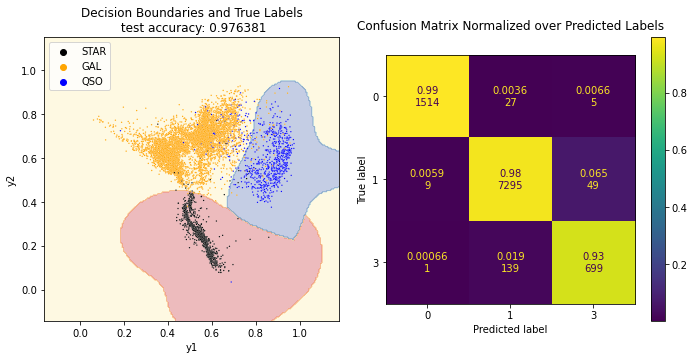

In [20]:
clf = SDRNNPClassifier(nnp_model_path=model_path, classifier=SVC(C=1.0, kernel="rbf", gamma="scale", random_state=seed)) # NB: to enable clf.predict_proba set probability=True
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=10, h=5)

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

fig.tight_layout()
plt.show()

## Use Neural Network to Classify the data

Accuracy: 0.975662
Precision:
	STAR : 0.992126
	GAL : 0.977093
	QSO : 0.927904

Recall:
	STAR : 0.978008
	GAL : 0.991976
	QSO : 0.828367

F1 score:
	STAR : 0.985016
	GAL : 0.984478
	QSO : 0.875315



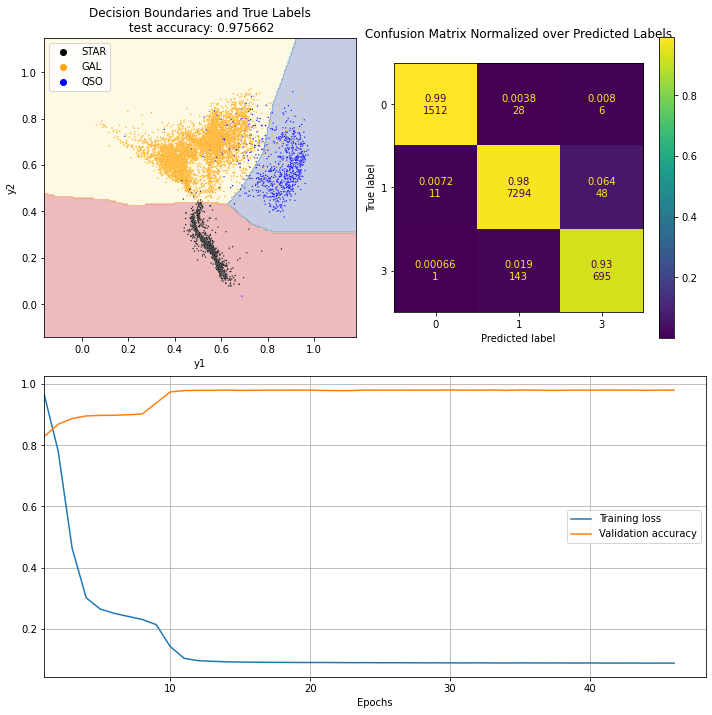

In [21]:
clf = SDRNNPClassifier(nnp_model_path=model_path,
                       classifier=MLPClassifier(hidden_layer_sizes=(20,10,5), activation="relu", solver="adam",
                                                max_iter=1000, early_stopping=True, validation_fraction=0.2,
                                                random_state=seed)) #NB: uses categorical cross-entropy loss (also called log-loss)
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig = plt.figure()
fig.set_size_inches(w=10, h=10)

gs = fig.add_gridspec(nrows=2, ncols=2)
axs = [fig.add_subplot(gs[0,i]) for i in range(2)] + [fig.add_subplot(gs[1,:])]

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

# plot loss curve
axs[2].plot(range(1, clf.classifier.n_iter_+1), clf.classifier.loss_curve_, label="Training loss")
axs[2].plot(range(1, clf.classifier.n_iter_+1), clf.classifier.validation_scores_, label="Validation accuracy")
axs[2].set_xlabel("Epochs")
axs[2].set_xlim((1,None))
axs[2].legend()
axs[2].grid()

fig.tight_layout()
plt.show()

## Classification using XGBoost Classifier

[23:48:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/users/lourens/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.976278
Precision:
	STAR : 0.992773
	GAL : 0.979812
	QSO : 0.910941

Recall:
	STAR : 0.977361
	GAL : 0.990072
	QSO : 0.853397

F1 score:
	STAR : 0.985007
	GAL : 0.984915
	QSO : 0.881231



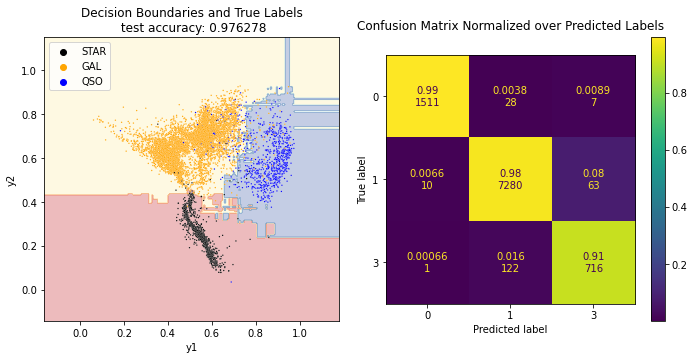

In [22]:
clf = SDRNNPClassifier(nnp_model_path=model_path, classifier=XGBClassifier(use_label_encoder=True, random_state=seed))
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=10, h=5)

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

fig.tight_layout()
plt.show()

## Classification using Dummy Classifier

Accuracy: 0.335079
Precision:
	STAR : 0.161092
	GAL : 0.752218
	QSO : 0.086916

Recall:
	STAR : 0.339586
	GAL : 0.334421
	QSO : 0.332539

F1 score:
	STAR : 0.218522
	GAL : 0.463001
	QSO : 0.137812



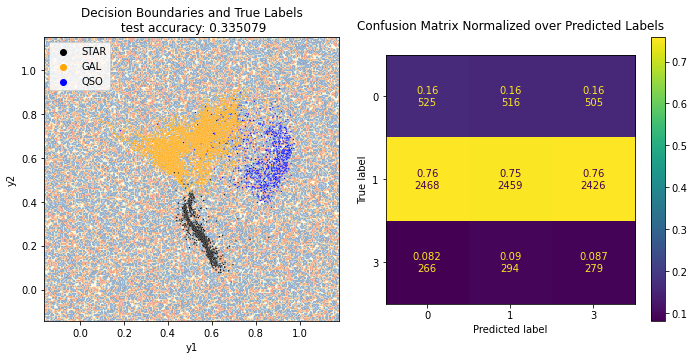

In [23]:
clf = SDRNNPClassifier(nnp_model_path=model_path, classifier=DummyClassifier(strategy="uniform", random_state=seed))
clf.fit(X_train, labels_train)

# evaluate performance
label_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, label_pred)
precision = precision_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
recall = recall_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned
f1 = f1_score(labels_test, label_pred, average=None) # NB: average=None ensures the scores for each class are returned

display_labels = ["STAR", "GAL", "QSO"]
print(f"Accuracy: {accuracy:.6f}")
print("Precision:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, precision)]))
print("Recall:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, recall)]))
print("F1 score:\n" + "".join([f"\t{k} : {v:.6f}\n" for k, v in zip(display_labels, f1)]))

# plots
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=10, h=5)

# plot domains
axs[0].set_aspect("equal")
axs[0].set_title(f"Decision Boundaries and True Labels\n test accuracy: {accuracy:.6f}")
clf.plot_classifier_decision_boundaries(ax=axs[0])
clf.plot_projection(X_test, y=labels_test, ax=axs[0])

# plot confusion matrix
axs[1].set_title("Confusion Matrix Normalized over Predicted Labels", pad=25)
disp_CM = CustomConfusionMatrixDisplay.from_predictions_with_counts(labels_test, label_pred, normalize="pred", ax=axs[1])

fig.tight_layout()
plt.show()